<a href="https://colab.research.google.com/github/pramud/100DaysOfKotlinAndVertx/blob/Day%231/RNN_unbounded_vocab_50_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize
# !pip install tensorflow-addons


In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow_addons as tfa

# import psutil
# import humanize
# import os, time
# import GPUtil as GPU

print(tf.__version__)

2.3.0


In [3]:
# GPUs = GPU.getGPUs()
# # only one GPU on Colab and isn’t guaranteed
# gpu = GPUs[0]
# def worker():
#   while True:
#     process = psutil.Process(os.getpid())
#     print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " I Proc size: " + humanize.naturalsize( process.memory_info().rss))
#     print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
#     time.sleep(6)

# import threading
# t = threading.Thread(target=worker, name='Monitor')
# t.start()

In [4]:
# import os
# os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [5]:
import matplotlib.pyplot as plt
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [8]:
data_df = pd.read_csv("/content/drive/My Drive/Colab_Notebooks/new.csv")

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
data_df.Reliability.value_counts()

2    50000
0    50000
Name: Reliability, dtype: int64

In [10]:
data_df.Reliability = data_df.Reliability.map({0:0, 2:1})

In [11]:
data_df.shape

(100000, 12)

In [12]:
data_df.content.drop_duplicates().shape

(96517,)

In [13]:
data_df['content'] = data_df['content'].str.replace('\n', ' ').str.strip()

In [14]:
data_df[(data_df.content.str.len()> 0) & (data_df.content.str.len()< 40)][['content','Reliability']]

,content,Reliability
155,"January 30, 2019 | 8:34 AM EST",1
194,"January 19, 2019 | 11:39 AM EST",1
322,read more at NewsBusters here,1
515,"February 13, 2019 | 1:05 AM EST",1
547,"January 28, 2019 | 3:34 PM EST",1
...,...,...
93012,Boris Johnson Needs to Get Serious,0
94080,Go to a Cheap College--or None at All,0
94479,Skip to main content,0
94634,# New state laws kick in for 2019,0


In [15]:
data_df.drop( data_df[data_df.content.str.len() < 50].index, inplace=True)

In [16]:
data_df[data_df.content.str.len() < 40]

,Unnamed: 0,id,date,source,title,content,author,url,published,published_utc,collection_utc,Reliability


In [17]:
# from collections import Counter
# alphabet_counter = lambda x: sum(list(Counter(c for c in x if c.isalpha()).values()))
# data_df["alpha_counts"] = data_df.content.apply(alphabet_counter)

In [18]:
# data_df[(data_df.alpha_counts< 13)][['content','Reliability']]

In [19]:
data_df.isnull().sum()

Unnamed: 0            0
id                    0
date                  0
source                0
title                 5
content               0
author            24459
url                   0
published            10
published_utc         0
collection_utc        0
Reliability           0
dtype: int64

In [20]:
data_df.head()

,Unnamed: 0,id,date,source,title,content,author,url,published,published_utc,collection_utc,Reliability
0,0,truepundit--2019-04-28--A Harvard Conference K...,2019-04-28,truepundit,A Harvard Conference Keynote Speaker Has Writt...,esHarvard University’s Faculty of Arts & Scien...,admin,https://truepundit.com/a-harvard-conference-ke...,2019-04-28 19:18:21+00:00,1556493501,1567541811,1
1,1,dailystormer--2019-01-07--PewDiePie is Going t...,2019-01-07,dailystormer,PewDiePie is Going to be Banned From YouTube N...,PewDiePie is Going to be Banned From YouTube N...,Andrew Anglin,https://dailystormer.name/pewdiepie-is-going-t...,2019-01-07 05:48:11+00:00,1546858091,1567553650,1
2,2,frontpagemagazine--2019-05-14--US Denies Visa ...,2019-05-14,frontpagemagazine,US Denies Visa to Terror Apologist Hanan Ashrawi,We've gone from one administration that had an...,Daniel Greenfield,https://www.frontpagemag.com/point/273770/us-d...,2019-05-14 04:28:45+00:00,1557822525,1567540763,1
3,3,rt--2019-02-02--Wasnt me I wore blackface on a...,2019-02-02,rt,"‘Wasn’t me, I wore blackface on another occasi...","Ralph Northam, who is under pressure to resign...",RT,https://www.rt.com/usa/450445-northam-racist-p...,2019-02-02 23:10:00+00:00,1549167000,1567549838,1
4,4,cnsnews--2019-08-12--Nancy Pelosi We Prayed fo...,2019-08-12,cnsnews,Nancy Pelosi: ‘We Prayed for Those…Whose Digni...,(CNSNews.com) - House Speaker Nancy Pelosi iss...,CNSNews.com Staff,https://www.cnsnews.com/news/article/cnsnewsco...,2019-08-12 16:37:07+00:00,1565642227,1567534336,1


In [21]:
#Keep only content, Reliability as columns
data_df = data_df.drop(['id','date','source','title','author','url','published','published_utc','collection_utc'],axis=1)

In [22]:
data_df.head()

,Unnamed: 0,content,Reliability
0,0,esHarvard University’s Faculty of Arts & Scien...,1
1,1,PewDiePie is Going to be Banned From YouTube N...,1
2,2,We've gone from one administration that had an...,1
3,3,"Ralph Northam, who is under pressure to resign...",1
4,4,(CNSNews.com) - House Speaker Nancy Pelosi iss...,1


In [23]:
# split the dataset into training and validation datasets 
train_x, valid_x, train_y, valid_y = train_test_split(data_df['content'], data_df['Reliability'], test_size=0.20, random_state=42)

In [24]:
train_y.value_counts(), valid_y.value_counts()

(0    39840
 1    39537
 Name: Reliability, dtype: int64, 1    10014
 0     9831
 Name: Reliability, dtype: int64)

In [25]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x.values, train_y.values))
test_dataset = tf.data.Dataset.from_tensor_slices((valid_x.values, valid_y.values))

In [ ]:
for feat, targ in train_dataset.take(5):
  print ('Features: {}, Target: {}'.format(feat, targ))

Features: b"Welcome to the Evening Standard\xe2\x80\x99s LIVE blog dedicated to the latest\xc2\xa0transfer news and rumours.  Chelsea will demand more than \xc2\xa3100m if Eden Hazard tells the club he wants to join Real Madrid, according to the Telegraph.  Ole Gunnar Solskjaer has moved into pole position to become Manchester United's next permanent boss, reports The Sun.  David de Gea wants to commit his long-term future to Manchester United but is awaiting a suitable offer, according to The Mail.  Jonjo Shelvey has been told he is staying at Newcastle amid interest from West Ham, reports The Mirror.  Meanwhile, Alvaro Morata is in talks with Atletico Madrid ahead of a move back to Spain, according to The Sun.  Marca in Spain say the striker is willing to take a pay cut to join Atleti.  We\xe2\x80\x99ll bring you today's football gossip and the latest from\xc2\xa0Arsenal,\xc2\xa0Man Utd,\xc2\xa0Chelsea,\xc2\xa0Liverpool,\xc2\xa0Tottenham,\xc2\xa0West Ham,\xc2\xa0Man City\xc2\xa0and m

In [26]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [27]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [28]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Two goals from Jamie Vardy helped Leicester City extend their unbeaten start to the season in a match that brought a fresh VAR controversy.  Vardy scored early in the first half and a points-clincher 17 minutes from the end. Youri Tielemans tapped in his first of the season in between and provided the assist for the third.  Yet it could be argued the Belgian was lucky still to be on the field after getting the benefit of the doubt following a VAR review of a studs-first challenge on Callum Wilson early in the second half with the score at 2-1.  Tielemans connected with the England striker\xe2\x80\x99s right ankle, which buckled on impact. It looked bad but, after consulting the VAR team referee Peter Bankes took no action. Happily, Wilson was able to resume after treatment, although he said later in an interview that \xe2\x80\x9che almost broke my ankle\xe2\x80\x9d.  \xe2\x80\x9cWatching it live, it looked over the top and he missed the ball,\xe2\x80\x9d Bournemouth manager 

**Create the text encoder**

In [29]:
# VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization()
encoder.adapt(train_dataset.map(lambda text, label: text))

The .adapt method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [30]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'to', 'of', 'and', 'a', 'in', 'that', 'is',
       'for', 'on', 'with', 'was', 'it', 'as', 'he', 'by', 'be', 'are'],
      dtype='<U971')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed output_sequence_length):

In [31]:
encoded_example = encoder(train_x.to_list()[1])[:3].numpy()
encoded_example

array([  6, 990,  21])

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy', tfa.metrics.F1Score(num_classes=2, average="micro", threshold=0.5 )])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
1241/1241 [==============================] - 671s 541ms/step - loss: 0.4234 - accuracy: 0.7708 - f1_score: 0.7301 - val_loss: 0.2884 - val_accuracy: 0.8750 - val_f1_score: 0.8756
Epoch 2/10
1241/1241 [==============================] - 671s 541ms/step - loss: 0.2048 - accuracy: 0.9143 - f1_score: 0.9113 - val_loss: 0.2526 - val_accuracy: 0.8932 - val_f1_score: 0.8944
Epoch 3/10
1241/1241 [==============================] - 673s 542ms/step - loss: 0.1086 - accuracy: 0.9586 - f1_score: 0.9578 - val_loss: 0.2842 - val_accuracy: 0.8901 - val_f1_score: 0.8887
Epoch 4/10
1241/1241 [==============================] - 671s 541ms/step - loss: 0.0531 - accuracy: 0.9814 - f1_score: 0.9812 - val_loss: 0.3347 - val_accuracy: 0.8875 - val_f1_score: 0.8889
Epoch 5/10
1241/1241 [==============================] - 674s 543ms/step - loss: 0.0275 - accuracy: 0.9909 - f1_score: 0.9909 - val_loss: 0.4118 - val_accuracy: 0.8828 - val_f1_score: 0.8826
Epoch 6/10
1241/1241 [============================

In [ ]:
test_loss, test_acc, test_f1_score = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

311/311 [==============================] - 42s 135ms/step - loss: 0.6402 - accuracy: 0.8745 - f1_score: 0.8745
Test Loss: 0.6401609778404236
Test Accuracy: 0.8745275735855103


(0.0, 0.7717186291236431)

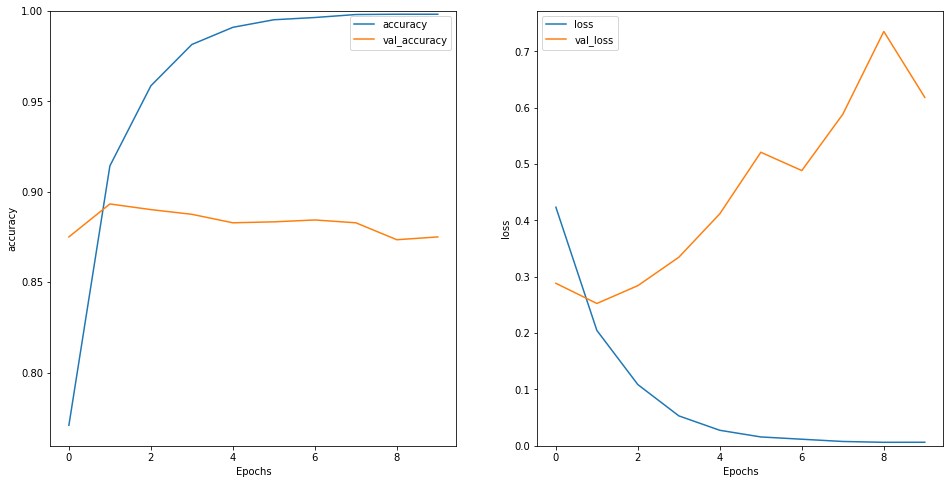

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

In [ ]:
#saving a model in HDF5 format
#model is a tf.keras.Model object created using any of the above methods
model.save("/content/drive/My Drive/Colab_Notebooks/rnn_lstm_new.tf", save_format='tf')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab_Notebooks/rnn_lstm_new.tf/assets


In [ ]:
tf.__version__

'2.3.0'

**Stacking more LSTM layers**

In [33]:
model2 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [34]:
model2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy', tfa.metrics.F1Score(num_classes=2, average="micro", threshold=0.5 )])

In [35]:
history2 = model2.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
1241/1241 [==============================] - 972s 784ms/step - loss: 0.4263 - accuracy: 0.7700 - f1_score: 0.7272 - val_loss: 0.2943 - val_accuracy: 0.8568 - val_f1_score: 0.8480
Epoch 2/10
1241/1241 [==============================] - 970s 781ms/step - loss: 0.2056 - accuracy: 0.9159 - f1_score: 0.9132 - val_loss: 0.2697 - val_accuracy: 0.8797 - val_f1_score: 0.8756
Epoch 3/10
1241/1241 [==============================] - 963s 776ms/step - loss: 0.1080 - accuracy: 0.9600 - f1_score: 0.9593 - val_loss: 0.3666 - val_accuracy: 0.8745 - val_f1_score: 0.8706
Epoch 4/10
1241/1241 [==============================] - 950s 766ms/step - loss: 0.0534 - accuracy: 0.9820 - f1_score: 0.9818 - val_loss: 0.4808 - val_accuracy: 0.8729 - val_f1_score: 0.8683
Epoch 5/10
1241/1241 [==============================] - 951s 767ms/step - loss: 0.0322 - accuracy: 0.9894 - f1_score: 0.9893 - val_loss: 0.5513 - val_accuracy: 0.8740 - val_f1_score: 0.8729
Epoch 6/10
1241/1241 [============================

In [36]:
test_loss, test_acc, test_f1_score = model2.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

311/311 [==============================] - 75s 241ms/step - loss: 0.8352 - accuracy: 0.8756 - f1_score: 0.8740
Test Loss: 0.8351673483848572
Test Accuracy: 0.8756361603736877


(0.0, 0.8717250059591606)

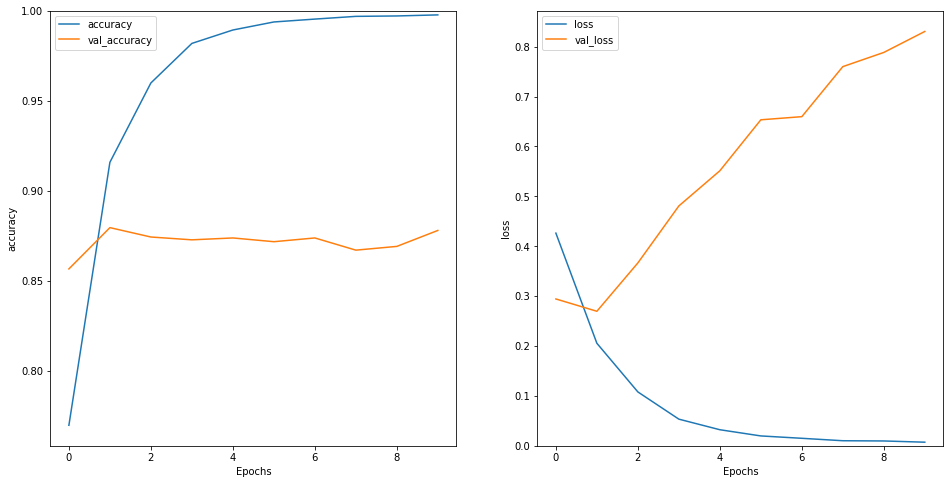

In [37]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history2, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history2, 'loss')
plt.ylim(0,None)

In [39]:
#saving a model in HDF5 format
#model is a tf.keras.Model object created using any of the above methods
model2.save("/content/drive/My Drive/Colab_Notebooks/rnn_lstm2_new.tf", save_format='tf')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab_Notebooks/rnn_lstm2_new.tf/assets


**GRU**